# **TextTorch - 05: Avaliação do Modelo**

**Objetivo:** Avaliar o desempenho do modelo treinado no conjunto de teste. Este notebook calcula métricas, gera visualizações e analisa os erros do modelo.

### **Como Executar (Google Colab)**

1. **Pré-requisito:** Execute os notebooks `01` a `04` para gerar todos os artefatos necessários (dataset, tensores, modelo treinado).
2. **Ambiente:** Se estiver em um novo ambiente, clone o repositório e instale as dependências.
   ```bash
   !git clone https://github.com/takaokensei/TextTorch.git
   %cd TextTorch
   !pip install -r requirements.txt
   ```
3. **Execução:** Execute todas as células.

In [1]:
# Imports e Configurações Iniciais
import sys
import os
import torch
import pickle
import numpy as np
from IPython.display import Image, display

# Adiciona o diretório 'src' ao path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from model import load_model, load_config
from train import create_dataloader, get_device
from evaluate import (
    evaluate_model, 
    plot_confusion_matrix, 
    plot_class_accuracy, 
    find_misclassified_examples,
    save_metrics
)

# Carrega configurações e define dispositivo
CONFIG_PATH = '../models/config.yaml'
config = load_config(CONFIG_PATH)
device = get_device()

print(f"Ambiente configurado. Usando dispositivo: {device}")

2025-11-13 17:30:49,456 - INFO - Configuração carregada de: ../models/config.yaml
2025-11-13 17:30:49,457 - INFO - Dispositivo detectado: cpu


Ambiente configurado. Usando dispositivo: cpu


## 1. Carregamento de Artefatos

Carregamos o modelo treinado, os tensores do conjunto de teste e o dataset processado (para obter os nomes das classes).

In [2]:
# Caminhos dos artefatos
MODEL_PATH = f"../models/{config['representation']}_model.pt"
TENSORS_PATH = f"../artifacts/tensors_{config['representation']}.pt"
DATASET_PATH = '../artifacts/processed_dataset.pkl'

# Carrega modelo
model = load_model(MODEL_PATH, device=device)

# Carrega tensores
data = torch.load(TENSORS_PATH)
X_test = data['X_test']
y_test = data['y_test']

# Carrega dataset para metadados
with open(DATASET_PATH, 'rb') as f:
    dataset = pickle.load(f)

class_names = dataset['class_names']

print("Modelo e dados de teste carregados.")

2025-11-13 17:30:52,840 - INFO - TFIDFClassifier criado: input=676, hidden=512, output=6
2025-11-13 17:30:52,842 - INFO - Modelo carregado de: ../models/tfidf_model.pt


Modelo e dados de teste carregados.


## 2. Avaliação no Conjunto de Teste

Executamos o modelo no conjunto de teste para obter as predições e calcular as métricas de desempenho.

In [3]:
# Cria DataLoader de teste
test_loader = create_dataloader(X_test, y_test, batch_size=config['batch_size'], shuffle=False)

# Avalia o modelo
metrics = evaluate_model(model, test_loader, device=device, class_names=class_names)

# Exibe o relatório de classificação
print("--- Relatório de Classificação ---")
print(metrics['classification_report'])

2025-11-13 17:30:55,565 - INFO - Avaliando modelo...
2025-11-13 17:30:55,586 - INFO - Avaliação concluída:
2025-11-13 17:30:55,587 - INFO -   Accuracy: 0.9688
2025-11-13 17:30:55,587 - INFO -   F1-Score (macro): 0.9634
2025-11-13 17:30:55,588 - INFO -   F1-Score (micro): 0.9688


--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         5
           4       0.86      1.00      0.92         6
           5       1.00      0.75      0.86         4

    accuracy                           0.97        32
   macro avg       0.98      0.96      0.96        32
weighted avg       0.97      0.97      0.97        32



## 3. Visualização dos Resultados

Geramos gráficos para interpretar visualmente o desempenho do modelo.

### 3.1. Matriz de Confusão

A matriz de confusão mostra os acertos e erros para cada classe, permitindo identificar quais classes o modelo confunde com mais frequência.

2025-11-13 17:31:03,858 - INFO - Matriz de confusão salva em: ../artifacts/plots/confusion_matrix.png


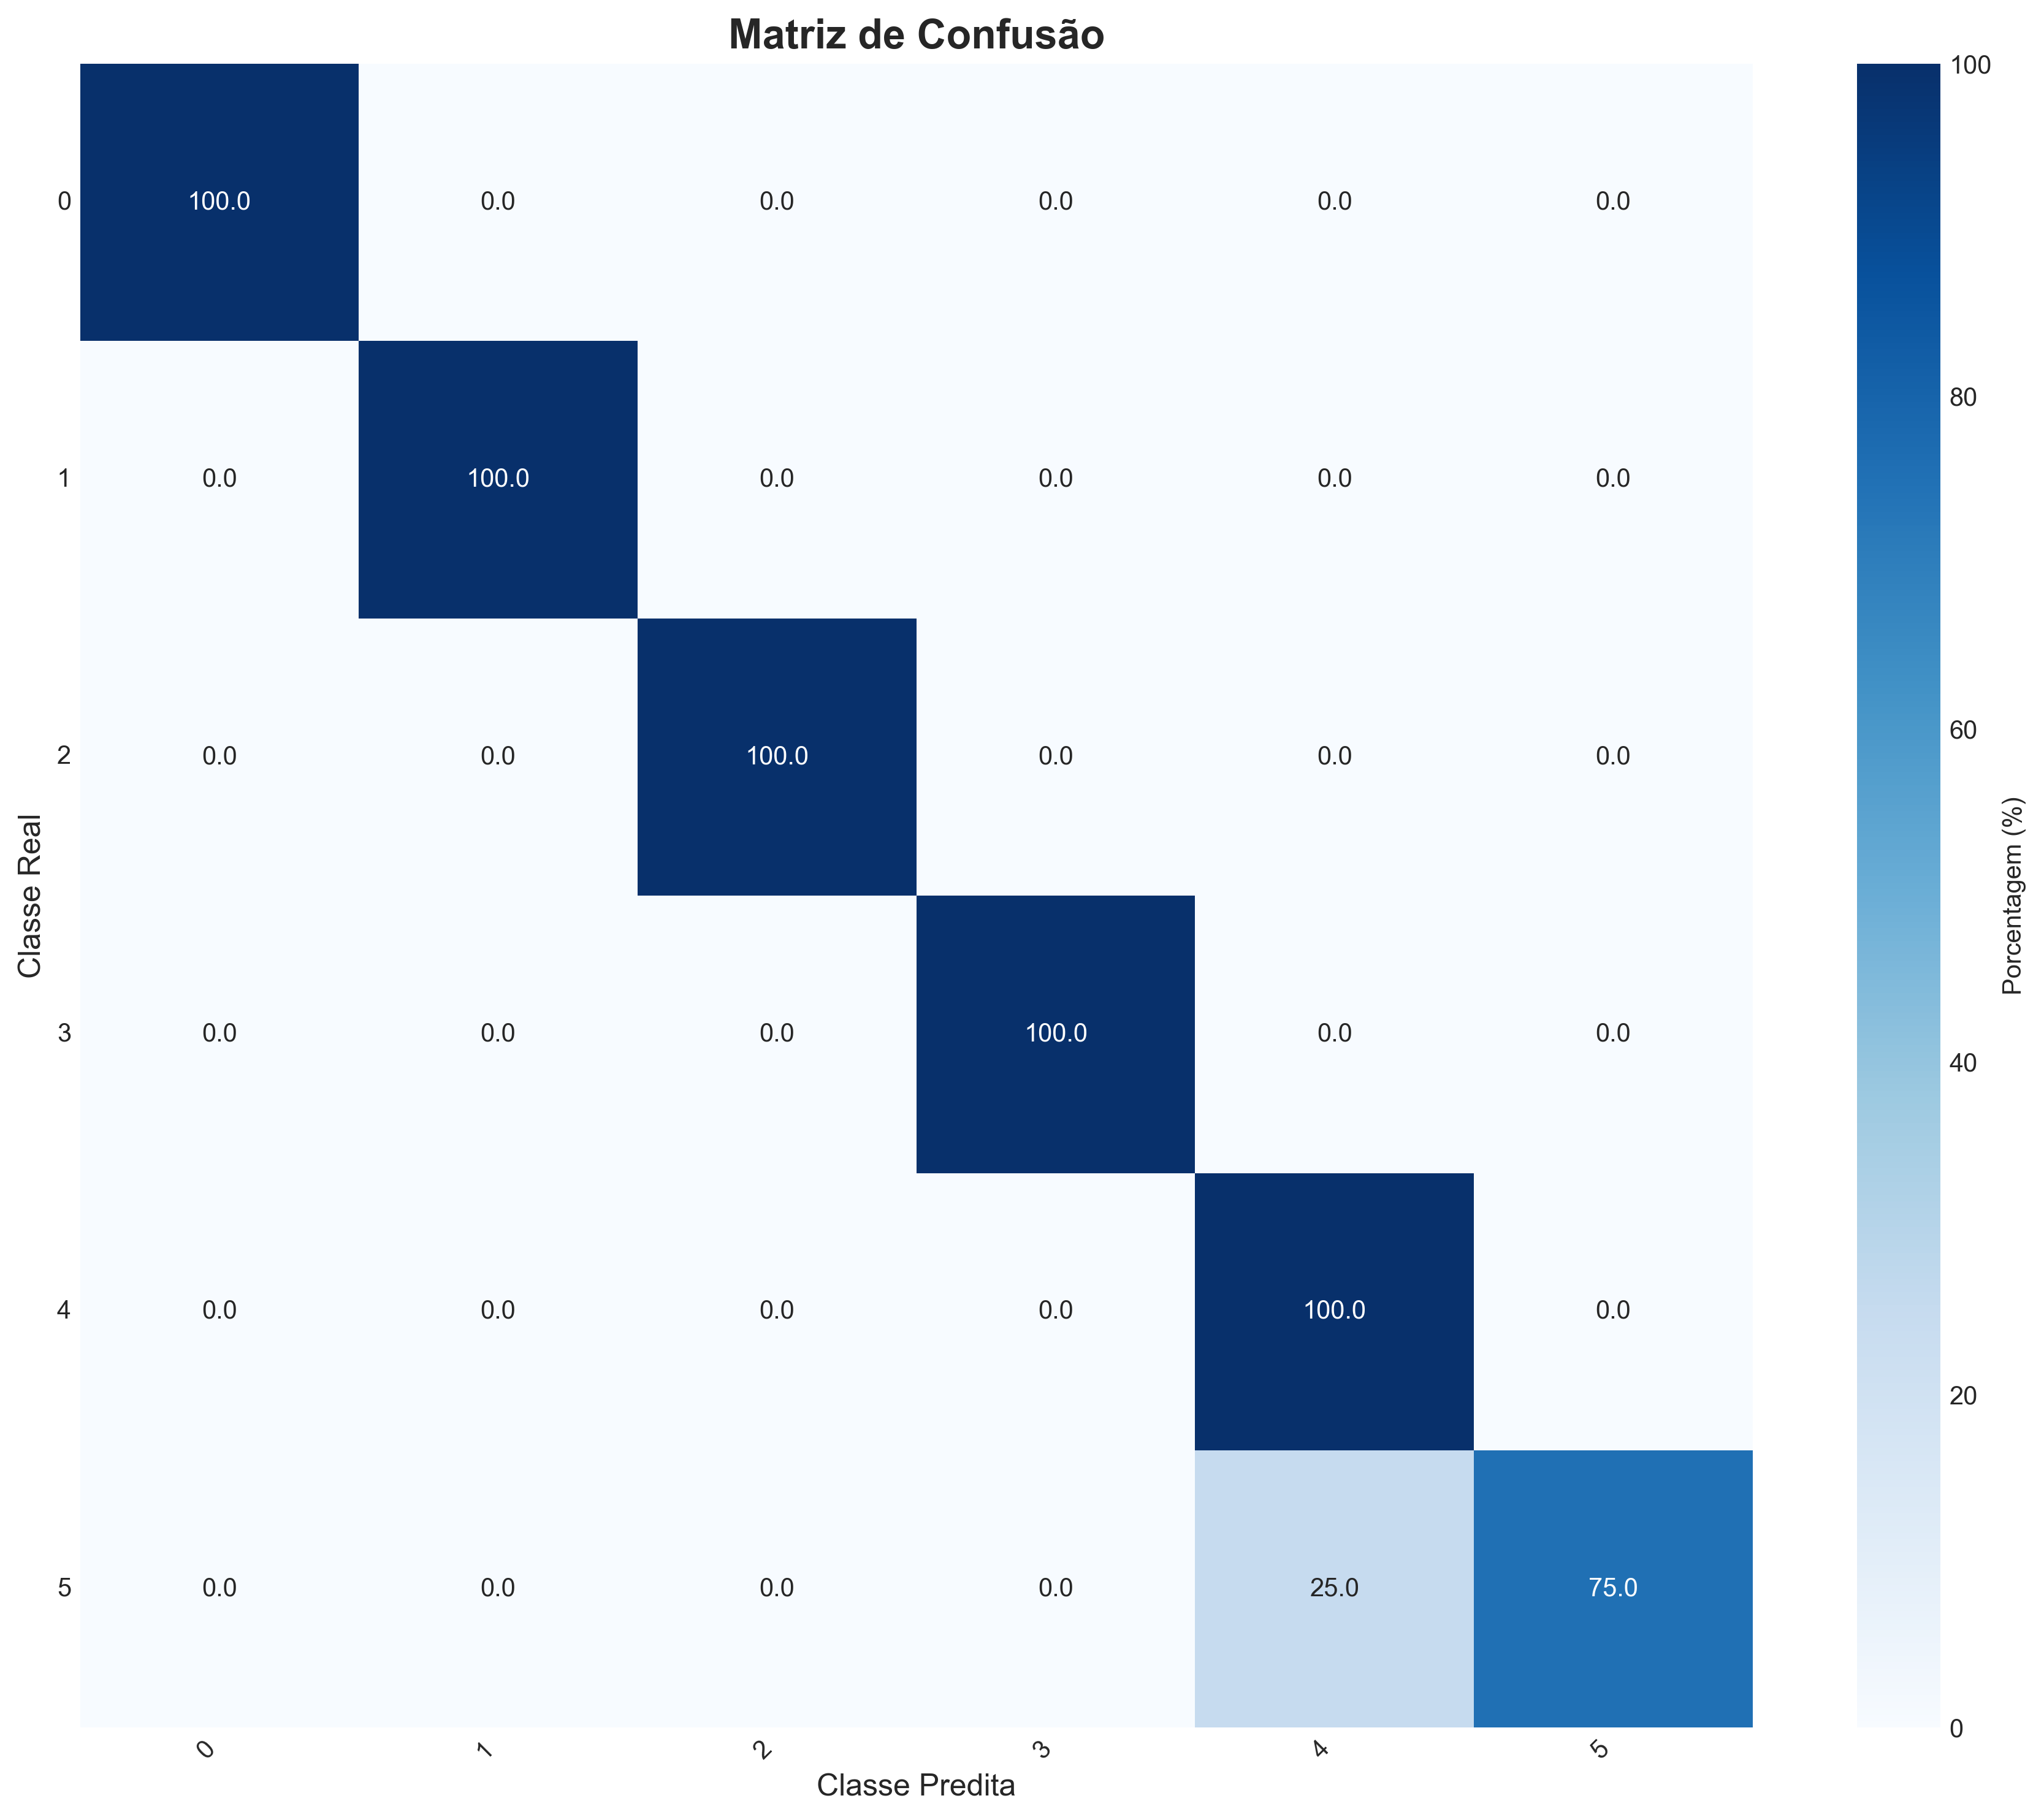

In [4]:
CM_PATH = '../artifacts/plots/confusion_matrix.png'
plot_confusion_matrix(np.array(metrics['confusion_matrix']), class_names, save_path=CM_PATH)

display(Image(filename=CM_PATH))

### 3.2. Desempenho por Classe

Este gráfico mostra o F1-Score para cada classe individualmente, facilitando a identificação das classes com melhor e pior desempenho.

2025-11-13 17:31:15,244 - INFO - Gráfico de acurácia por classe salvo em: ../artifacts/plots/class_accuracy.png


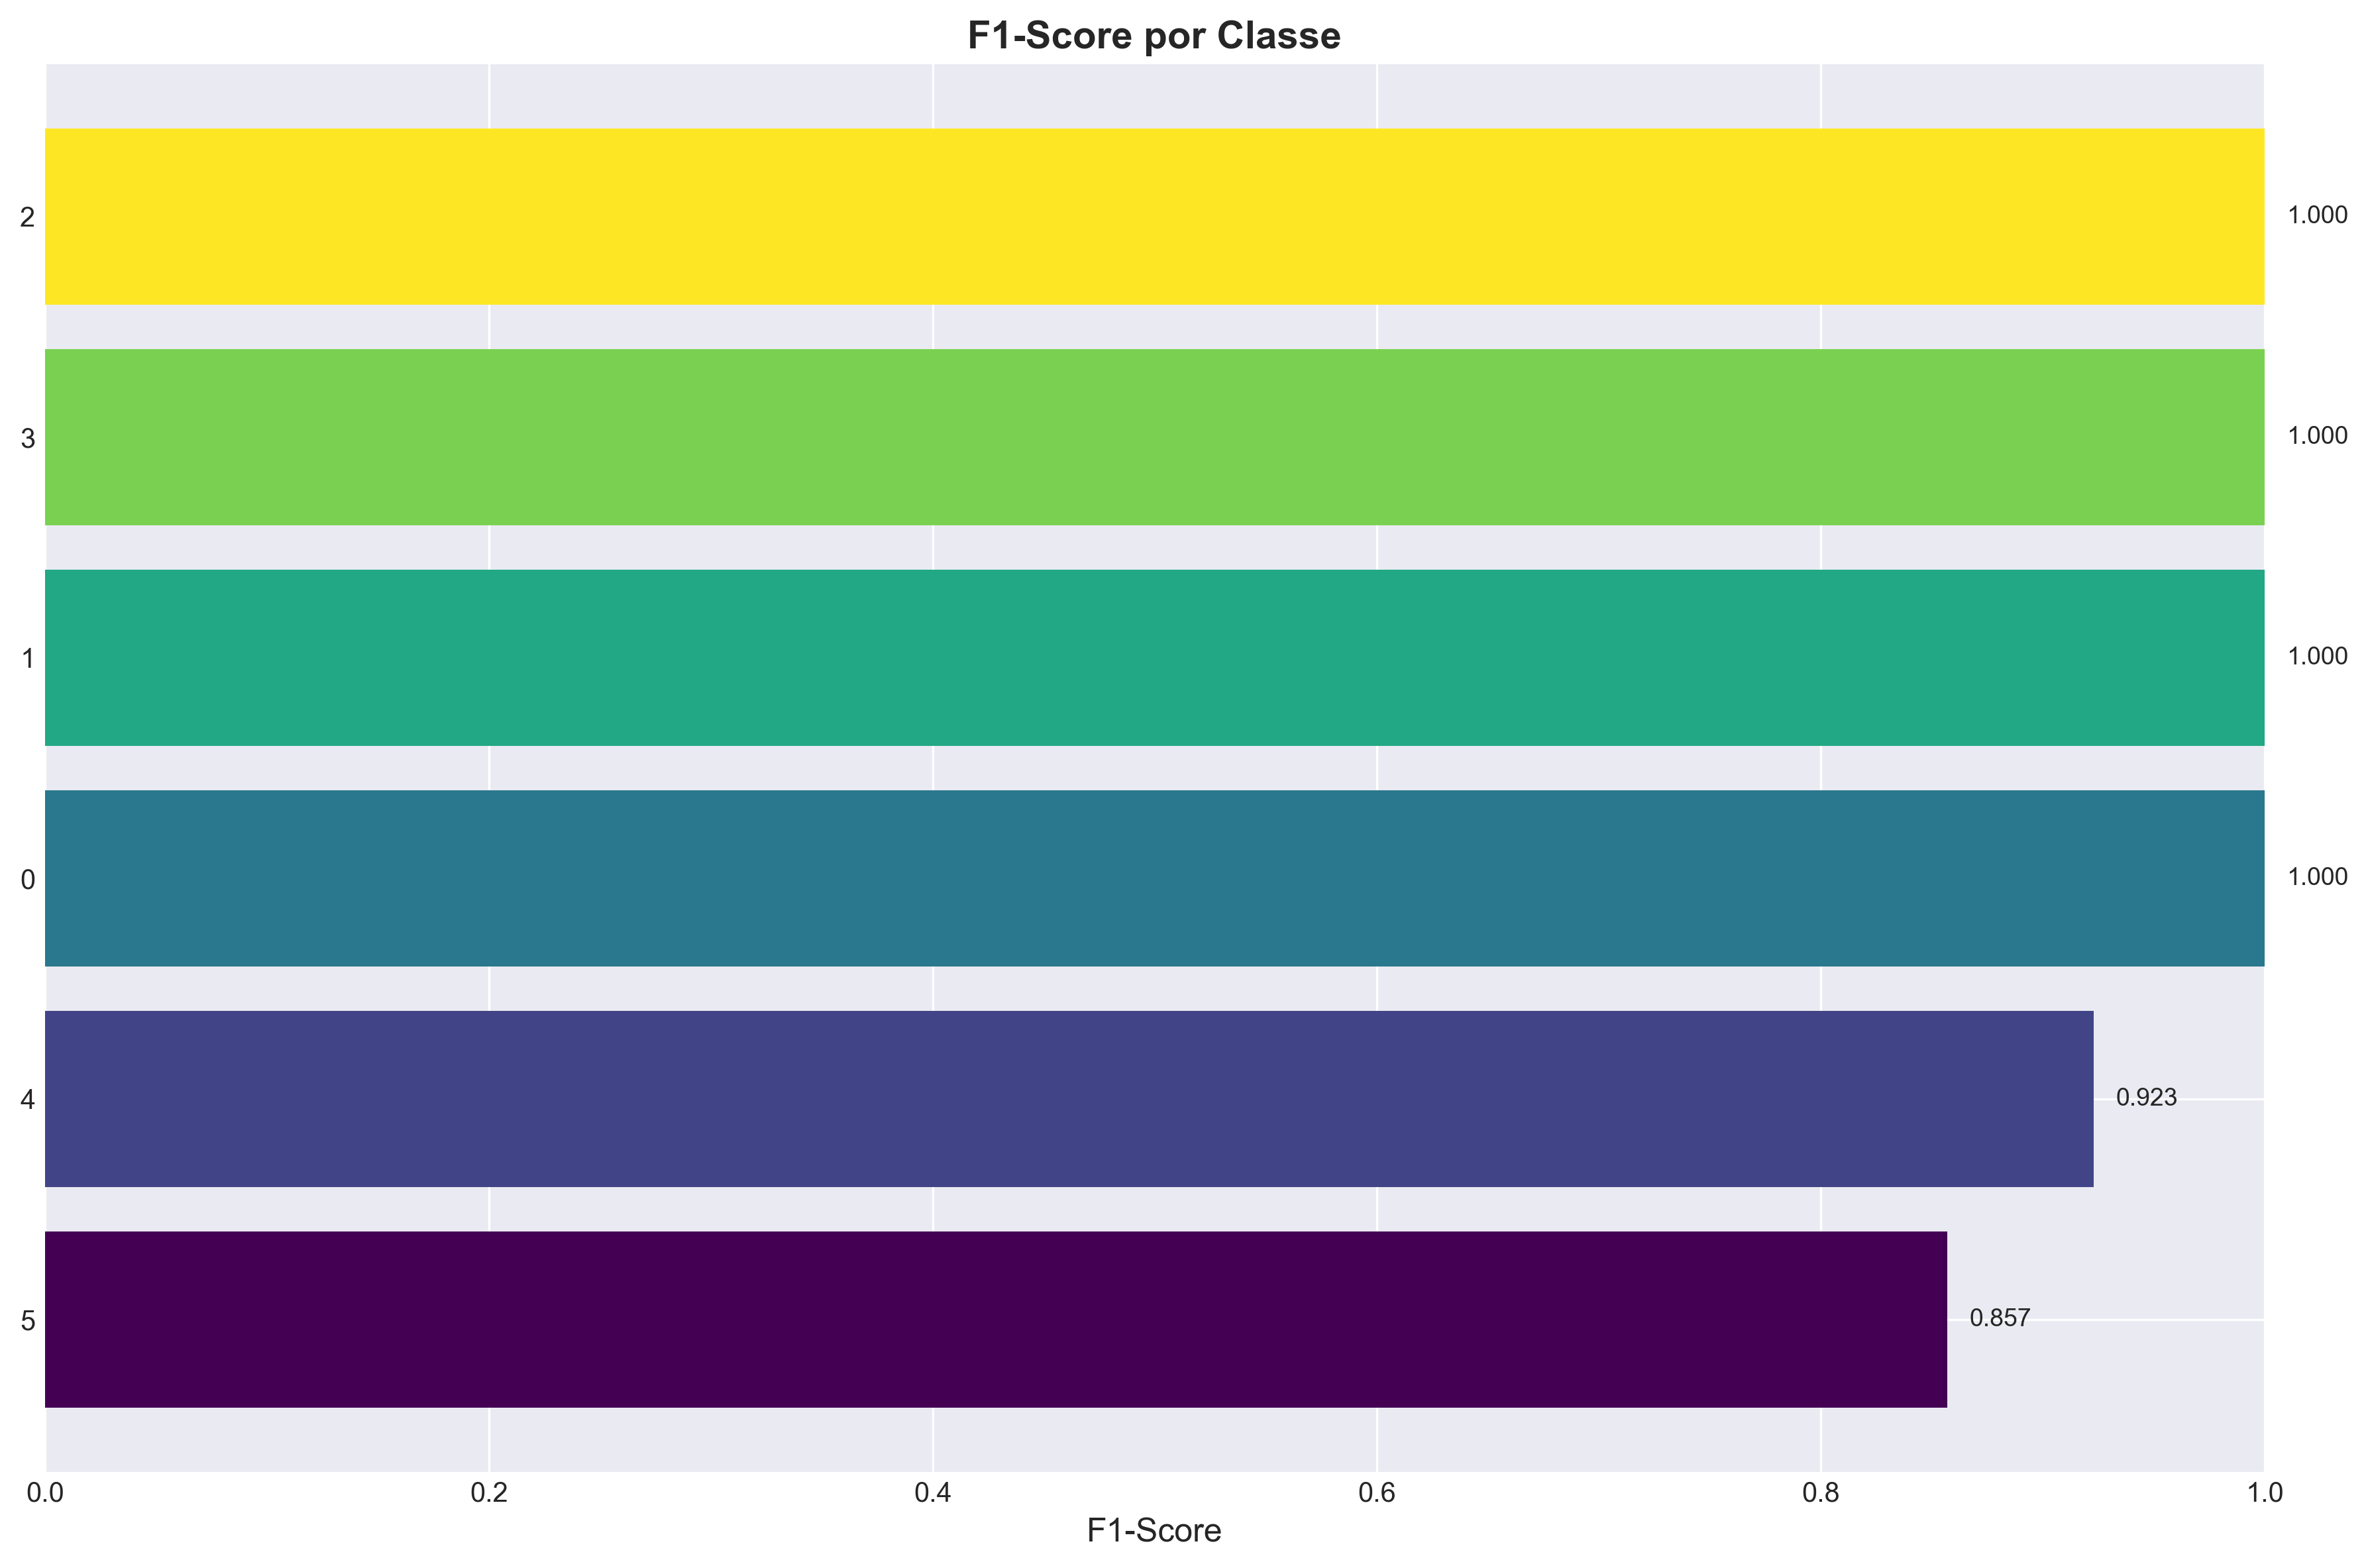

In [5]:
ACC_CLASS_PATH = '../artifacts/plots/class_accuracy.png'
plot_class_accuracy(metrics, class_names, save_path=ACC_CLASS_PATH)

display(Image(filename=ACC_CLASS_PATH))

## 4. Análise de Erros

Analisar os exemplos que o modelo classificou incorretamente pode fornecer insights valiosos sobre suas limitações. Focamos nos erros que o modelo cometeu com maior confiança.

In [8]:
# Encontra os 10 piores erros
misclassified = find_misclassified_examples(
    metrics=metrics,
    texts=dataset['X_test'],
    class_names=class_names,
    top_n=10
)

print("--- Top 10 Erros (com maior confiança na predição errada) ---")
for i, item in enumerate(misclassified):
    print(f"\n{i+1}. Confiança: {item['confidence']:.2%}")
    print(f"   - Texto: '{item['text']}'")
    print(f"   - Real:    {item['true_label']}")
    print(f"   - Predito: {item['predicted_label']}")

--- Top 10 Erros (com maior confiança na predição errada) ---

1. Confiança: 64.87%
   - Texto: 'descubra a riqueza da diversidade brasileira através de manifestações artísticas contemporâneas que celebram a complexidade étnica  cultural e histórica do país  uma polifonia de expressões que revela...'
   - Real:    5
   - Predito: 4


## 5. Salvando as Métricas

Salvamos um resumo das métricas em um arquivo JSON para documentação e futuras comparações.

In [9]:
METRICS_PATH = '../artifacts/metrics.json'
save_metrics(metrics, save_path=METRICS_PATH)

print(f"Métricas salvas em: {METRICS_PATH}")

2025-11-13 17:31:43,739 - INFO - Métricas salvas em: ../artifacts/metrics.json


Métricas salvas em: ../artifacts/metrics.json
